# Tutorial 3: Initializing a large-scale chain

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('..')
from gstatsmcmc import Topography
from gstatsmcmc import MCMC
import gstatsim as gs
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg
import config

In [3]:
# load compiled bed elevation measurements
df = pd.read_csv('./BindSchalder_Macayeal_IceStreams.csv')

In [4]:
# create a grid of x and y coordinates
x_uniq = np.unique(df.x)
y_uniq = np.unique(df.y)

xmin = np.min(x_uniq)
xmax = np.max(x_uniq)
ymin = np.min(y_uniq)
ymax = np.max(y_uniq)

cols = len(x_uniq)
rows = len(y_uniq)

resolution = 500

xx, yy = np.meshgrid(x_uniq, y_uniq)

In [5]:
# load other data
dhdt = df['dhdt'].values.reshape(xx.shape)
smb = df['smb'].values.reshape(xx.shape)
velx = df['velx'].values.reshape(xx.shape)
vely = df['vely'].values.reshape(xx.shape)
bedmap_mask = df['bedmap_mask'].values.reshape(xx.shape)
bedmachine_thickness = df['bedmachine_thickness'].values.reshape(xx.shape)
bedmap_surf = df['bedmap_surf'].values.reshape(xx.shape)
highvel_mask = df['highvel_mask'].values.reshape(xx.shape)
bedmap_bed = df['bedmap_bed'].values.reshape(xx.shape)

In [6]:
bedmachine_bed = bedmap_surf - bedmachine_thickness

In [7]:
# create conditioning data
# bed elevation measurement in grounded ice region, and bedmachine bed topography elsewhere
cond_bed = np.where(bedmap_mask == 1, df['bed'].values.reshape(xx.shape), bedmap_bed)
df['cond_bed'] = cond_bed.flatten()

# create a mask of conditioning data
data_mask = ~np.isnan(cond_bed)

(-997500.0, -408500.0, -1057000.0, -550500.0)

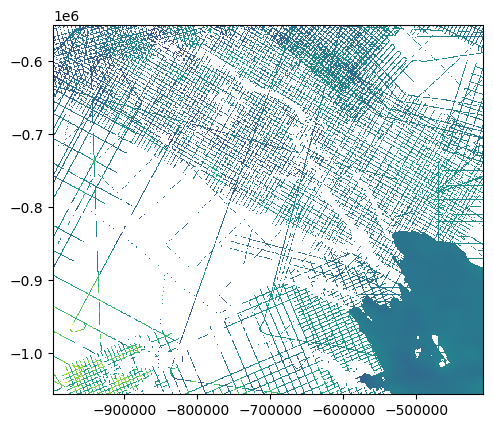

In [8]:
plt.pcolormesh(xx,yy,cond_bed)
plt.axis('scaled')

In [9]:
# normalize the conditioning bed data, saved to df['Nbed']
data = df['cond_bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal",random_state=0).fit(data)
transformed_data = nst_trans.transform(data)
df['Nbed'] = transformed_data

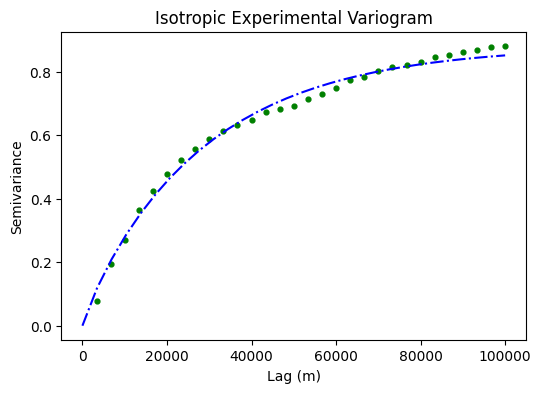

In [10]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.10, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = 100000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

V1_p = V1.parameters

# evaluate models
xi = np.linspace(0, xdata[-1], n_lags) 
y_mtn = [skg.models.matern(h, V1_p[0], V1_p[1], V1_p[2], V1_p[3]) for h in xi]
# variogram parameter is [range, sill, shape, nugget] for matern model.

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.plot(xi, y_mtn,'b-.', label='Matern variogram model')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

In [11]:
V1_p

[82874.01611495872, 0.882571527576134, 0.4423622047873629, 0]

In [12]:
#V1_p = [83251.42284193831, 1.8417237215825735, 0.9952450731725953, 0]

In [13]:
# load bed generated by Sequential Gaussian Simulation
sgs_bed = np.loadtxt('./sgs_bed_bindshalder.txt')
thickness = bedmap_surf - sgs_bed
sgs_bed = np.where((thickness<=0)&(bedmap_mask==1), bedmap_surf-1, sgs_bed)

### Then initiating the chain

#### Initiate an object of the class chain_crf

Let's first initiate the chain. Here, we created an object of the class chain_crf. This initialization process requires several input that are essential for later calculations

In [14]:
grounded_ice_mask = (bedmap_mask == 1)

In [15]:
largeScaleChain = MCMC.chain_crf(xx, yy, sgs_bed, bedmap_surf, velx, vely, dhdt, smb, cond_bed, data_mask, grounded_ice_mask, resolution)

before running the chain, please set where the block update will be using the object's function set_update_region(update_in_region, region_mask)
then please set up the loss function using either set_loss_type or set_loss_func
an RandField object also need to be created correctly and passed in set_crf_data_weight(RF) and in run(n_iter, RF)


Now, the object 'largeScaleChain' have all the properties you have assigned in the initialization process. Try typing *largeScaleChain.xx* or *largeScaleChain.cond_bed*, or any other argument to check them.

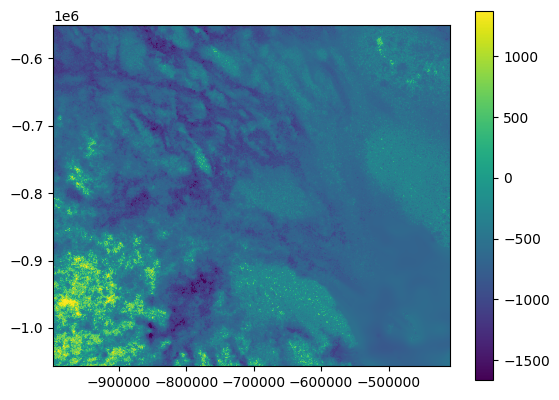

In [16]:
plt.pcolormesh(xx, yy, largeScaleChain.initial_bed)
plt.axis('scaled')
plt.colorbar()

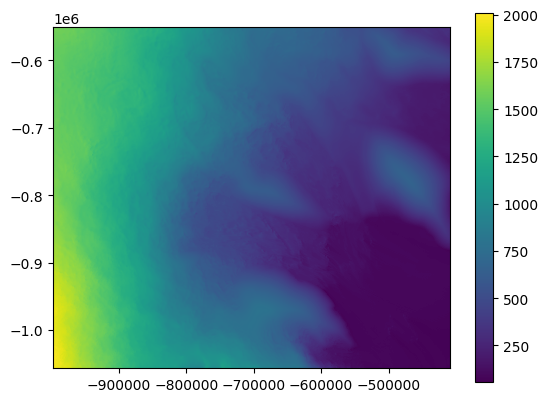

In [17]:
plt.pcolormesh(xx, yy, largeScaleChain.surf)
plt.axis('scaled')
plt.colorbar()

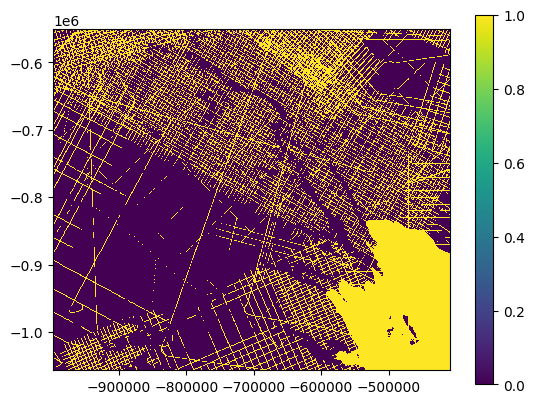

In [18]:
plt.pcolormesh(xx, yy, largeScaleChain.data_mask)
plt.axis('scaled')
plt.colorbar()

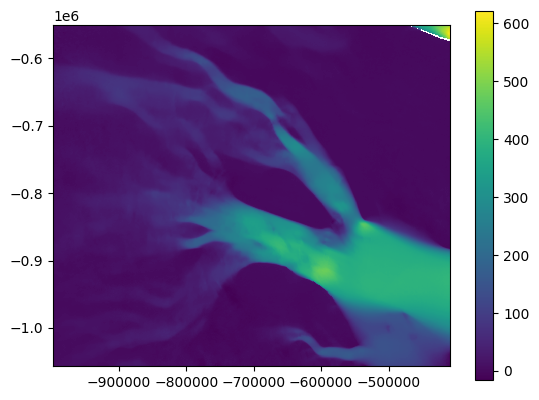

In [19]:
plt.pcolormesh(xx, yy, largeScaleChain.velx)
plt.axis('scaled')
plt.colorbar()

In [20]:
 largeScaleChain.grounded_ice_mask[-1,-1]

True

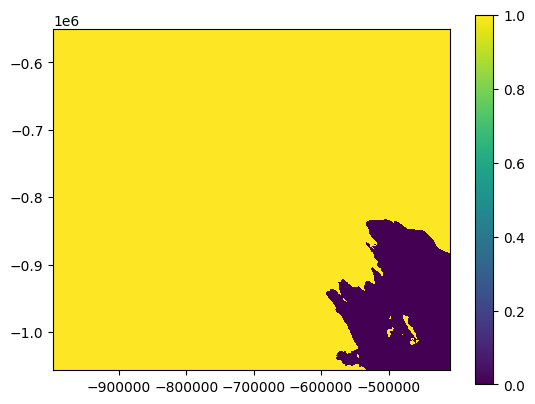

In [21]:
plt.pcolormesh(xx, yy, largeScaleChain.grounded_ice_mask)

plt.axis('scaled')
plt.colorbar()

The second function required, is *set_update_region*. In this function, the first boolean argument decide whether the MCMC update will be inside the high velocity, the second argument specify the exact region of high velocity (where the high_vel_mask == 1)

In [22]:
largeScaleChain.set_update_region(True,highvel_mask)

the update blocks is set to be randomly generated for any locations inside the given region


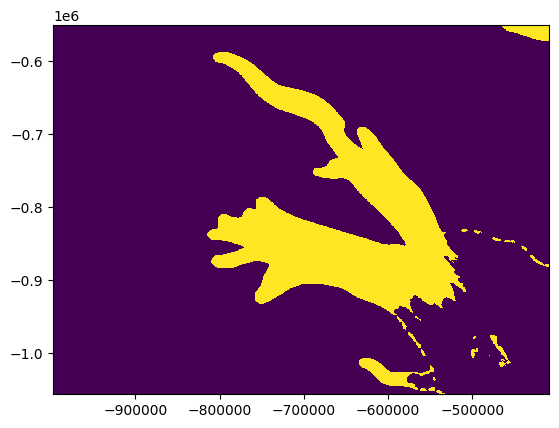

In [23]:
plt.pcolormesh(xx,yy,highvel_mask)

We also want to specify how we want to define the loss function used in the chain.

*map_func* determine the distribution of mass conservation residuals, whereas the *diff_func* determine the distribution of the difference between radar measurements and simulated topography. If the residuals has a Gaussian distribution, the corresponding function will be 'sumsquare'. If you do not want to include either of these loss, simple put *map_func = None* or *diff_func = None*. 

*sigma_mc* and *sigma_data* determine the standard deviation of the distribution of mass conservation residual or differences to radar data. *massConvInRegion* and *dataDiffInRegion* specify whether the two losses should be calculated for only inside the high velocity region or not

In [24]:
mc_res_bm = Topography.get_mass_conservation_residual(bedmachine_bed,bedmap_surf,velx,vely,dhdt,smb,resolution)

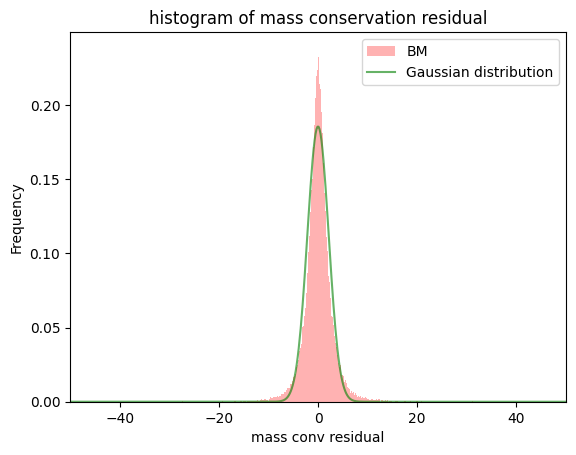

In [26]:
sigma3 = config.sigma3
xl3=np.linspace(-100, 100, num=1000)
gaussian_model=1/(sigma3*np.sqrt(2*np.pi))*np.exp(-0.5*np.square(xl3/sigma3))

# here, we filter mc_res_bm to only account for mass flux residuals inside the high velocity region
mc_res_bm_sr2 = mc_res_bm[highvel_mask==1]
mc_res_bm_sr2_f = mc_res_bm_sr2.flatten()
mc_res_bm_sr2_f = mc_res_bm_sr2_f[~np.isnan(mc_res_bm_sr2_f)]

plt.hist(mc_res_bm_sr2_f, bins=5000, facecolor='red', alpha=0.3,density=True,label='BM')
plt.plot(xl3, gaussian_model, color='Green',alpha=0.6, label='Gaussian distribution')
plt.xlim([-50,50]);

plt.legend()
plt.xlabel('mass conv residual');
plt.ylabel('Frequency');
plt.title('histogram of mass conservation residual')
plt.show()

Setting up the loss function for the large-scale chain. Here, we only use mass conservation residuals as the loss and ignore the different to bed elevation measurements, because the chains will always perserve the radar measurements.

Use 'sumsquare' will set the loss function as sum of squared mass conservation residuals inside the high-velocity region, which represent the pdf of a Gaussian distribution with standard deviation 'sigma_mc'

In [27]:
largeScaleChain.set_loss_type(map_func='sumsquare', sigma_mc=config.sigma3, massConvInRegion=True)
print(f"Deviation: {sigma3}")

Deviation: 2.15


To directly calculate the loss of BedMachine topography in terms of mass conservation residuals, we can directly calls:

largeScaleChain.loss(mass_conservation_residuals, difference_to_radar_measurements)

the _loss()_ function returns three values: the total loss, mass conservation loss (loss based on mass conservation residuals) and measurements data loss (loss based on differences between the topography and the radar measurements). The total loss equals mass conservation loss plus radar measurements loss.

Because we only set-up the mass conservation loss, the difference_to_radar_measurements can be left out

In [28]:
print("Loss 1:", largeScaleChain.loss(mc_res_bm, 0))
print("Loss 2:" , largeScaleChain.loss(mc_res_bm, bedmachine_bed - cond_bed))
assert largeScaleChain.loss(mc_res_bm, 0) == largeScaleChain.loss(mc_res_bm, bedmachine_bed - cond_bed)

Loss 1: (182270.73586298342, 182270.73586298342, 0.0)
Loss 2: (182270.73586298342, 182270.73586298342, 0.0)


For more information regarding these two functions, please check the documentation for MCMC.py

An example of setting up both mass conservation loss and measurements data loss

largeScaleChain.set_loss_type(map_func='sumsquare', sigma_mc=5, massConvInRegion=True,
                             diff_func='sumsquare', sigma_data=10, dataDiffInRegion=True)

Then the loss function will return different things

largeScaleChain.loss(mc_res_bm, bedmachine_bed - cond_bed)

will returns, for example

(2206762.607690888, 139380.26325314105, 2067382.3444377468)

Here, the three values represents the total loss, the mass conservation loss, and the radar measurements loss.

In [29]:
V1_p

[82874.01611495872, 0.882571527576134, 0.4423622047873629, 0]

#### Initiate an object of the class RandField

Next step is to set up the parameters of the random field perturbation

In [30]:
#range_max and range_min changes topographies features' lateral scale
#by default, I set range_max to variogram range
range_max_x = V1_p[0] #in terms of meters in lateral dimension, regardless of resolution of the map
range_max_y = V1_p[0]
range_min_x = 10e3
range_min_y = 10e3
scale_min = 50 #in terms of meters in vertical dimension, how much you want to multiply the perturbation by
scale_max = 150
nugget_max = 0
random_field_model = 'Matern' # currently only supporting 'Gaussian' or 'Exponential'
isotropic = True
smoothness = V1_p[2]

rf1 = MCMC.RandField(range_min_x, range_max_x, range_min_y, range_max_y, scale_min, scale_max, nugget_max, random_field_model, isotropic, smoothness = smoothness)

Before using the `RandField` object in an MCMC chain or for field generation, call method `set_block_sizes` and method`set_weight_param` to initialize block size ranges and conditional weighting parameters.


Then we can set up the size of the blocks used in the update

*set_block_sizes* function create a list of possible block sizes, which will be accessible via rf1.pairs after the function is called.

*set_block_sizes* function also has an optional argument *steps*, it specify how many 'steps' between the min_block and max_block will be divided into. For example, for min_block_x = 20 and max_block_x = 50, steps = 4 will divide the range into [20, 30, 40, 50]. For min_block_y = 10 and max_block_y = 55, it will divide the range into [10, 25, 40, 55]. Then each size on the list for x will pair up with all size on the list for y, creating a list of following

rf1.pairs = [[20,10],[20,25],[20,40],[20,55],[30,10],[30,25],[30,40],[30,55],[40,10],[40,25],[40,40],[40,55],[50,10],[50,25],[50,40],[50,55]]

When randomly deciding the size of the block, one of the size on the list will be chosen and will be used

In [31]:
min_block_x = 50
max_block_x = 80
min_block_y = 50
max_block_y = 80
rf1.set_block_sizes(min_block_x, max_block_x, min_block_y, max_block_y)

Finally, if you wish to use conditional block update, then the RandField object requires specifying the logistic function used to calculate the conditioning weight of the random field

The logistic function is used to calculate the weight for conditioning to the edge of the block and the weight for conditioning to radar measurements. When updating the field, the weight will be 1 at conditioning data and block edges, and it logistically decays to 0 at location *max_dist* away from any conditioning data

In [32]:
logis_func_L = 2
logis_func_x0 = 0
logis_func_k = 6
logis_func_offset = 1
max_dist = V1_p[0] # set to the distance between two points on the map where the correlation vanish / is minimal

rf1.set_weight_param(logis_func_L, logis_func_x0, logis_func_k, logis_func_offset, max_dist, resolution)

#### Run the Markov chain

At last, these information need to be known to the crf chain. The function *set_crf_data_weight* calculate the weight for conditioning to the radar measurements

In [ ]:
"""
largeScaleChain.set_crf_data_weight(rf1)
largeScaleChain.set_update_type('CRF_weight')
"""

In [ ]:
np.savetxt('data_weight.txt', largeScaleChain.crf_data_weight)

In [33]:
largeScaleChain.crf_data_weight = np.loadtxt('data_weight.txt',dtype=np.float64) 
largeScaleChain.set_update_type('CRF_weight')

The update block is set to conditional random field generated by calculating weights with logistic function


In [34]:
sys.getsizeof(largeScaleChain.crf_data_weight), ((largeScaleChain.crf_data_weight)[0,0])

(9546640, 0.14446362510365307)

And then we can start the chain by specifying how many iterations it should go through

In [35]:
seed = 20251019
rng = np.random.default_rng(seed)
all_topography = []


In [46]:
# Load our previous bed 
INITIAL_BED = np.loadtxt('./0final_bed_largeCRF.txt')    
NUMBER_OF_ITERATIONS = 20000
index_we_want_compare = 36
last_iterated_bed = np.loadtxt(f'./SGS_realizations/{index_we_want_compare}final_bed_largeCRF.txt')    


largeScaleChain.initial_bed = last_iterated_bed


print(index_we_want_compare)


36


In [ ]:
i = index_we_want_compare + 1
for _ in range(1):
    print(f"--- Starting {i * NUMBER_OF_ITERATIONS / 1000}(k)th Chain ---")
    current_beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used  = largeScaleChain.run(n_iter=NUMBER_OF_ITERATIONS, 
                                                                                                RF=rf1, 
                                                                                                rng_seed=rng, 
                                                                                                only_save_last_bed=True, 
                                                                                                info_per_iter = 1000)
    largeScaleChain.initial_bed = current_beds
    #current_final_bed = largeScaleChain.initial_bed 
    np.savetxt(f'{i}final_bed_largeCRF.txt', current_beds)  
    np.savetxt(f'{i}_loss_largeCRF.txt', loss)    
    np.savetxt(f'{i}_step_largeCRF.txt', steps)    
    i += 1

--- Starting 740.0(k)th Chain ---
i: 1000 mc loss: 2.905e+06 data loss: 0.000e+00 loss: 2.905e+06 acceptance rate: 0.4995004995004995
i: 2000 mc loss: 2.903e+06 data loss: 0.000e+00 loss: 2.903e+06 acceptance rate: 0.5102448775612194
i: 3000 mc loss: 2.901e+06 data loss: 0.000e+00 loss: 2.901e+06 acceptance rate: 0.5018327224258581
i: 4000 mc loss: 2.899e+06 data loss: 0.000e+00 loss: 2.899e+06 acceptance rate: 0.5001249687578105
i: 5000 mc loss: 2.897e+06 data loss: 0.000e+00 loss: 2.897e+06 acceptance rate: 0.4979004199160168
i: 6000 mc loss: 2.895e+06 data loss: 0.000e+00 loss: 2.895e+06 acceptance rate: 0.4962506248958507
i: 7000 mc loss: 2.893e+06 data loss: 0.000e+00 loss: 2.893e+06 acceptance rate: 0.49950007141836883
i: 8000 mc loss: 2.891e+06 data loss: 0.000e+00 loss: 2.891e+06 acceptance rate: 0.4969378827646544
i: 9000 mc loss: 2.889e+06 data loss: 0.000e+00 loss: 2.889e+06 acceptance rate: 0.4993889567825797
i: 10000 mc loss: 2.886e+06 data loss: 0.000e+00 loss: 2.886e+06 

### Verify Results

We can check several aspects of the results:

- How the topography deviate from radar measurements

- Mass flux residuals of the current topography

- How loss reduce over time

- Variogram of the simulated topography

In [37]:
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import LightSource, Normalize
from matplotlib.patches import Patch

In [38]:
loss_bedmachine = largeScaleChain.loss(mc_res_bm, bedmachine_bed - cond_bed)
loss_mcmc = np.loadtxt(f'./SGS_realizations/{index_we_want_compare}_loss_largeCRF.txt')
loss_bedmachine, loss_mcmc[0], loss_mcmc[-1], loss_mcmc

((182270.73586298342, 182270.73586298342, 0.0),
 2955345.6826253585,
 2907525.420965864,
 array([2955345.68262536, 2955336.38357491, 2955335.98683919, ...,
        2907526.96640893, 2907525.42096586, 2907525.42096586]))

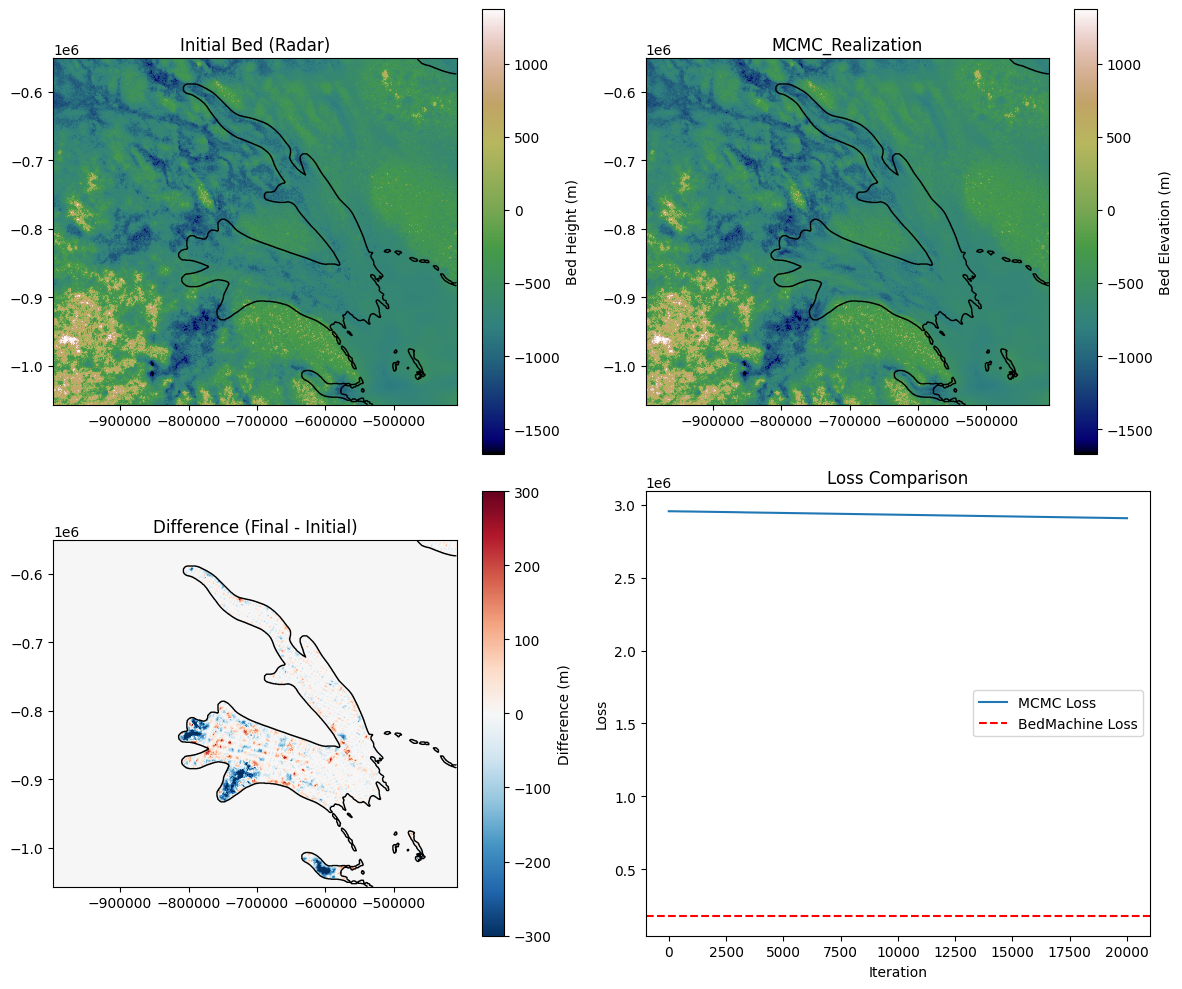

In [39]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 10))
current_beds = last_iterated_bed
# --- Plot 1: Initial bed (top-left) ---
ax = axes[0, 0]
im1 = ax.pcolormesh(xx, yy, INITIAL_BED, cmap='gist_earth')
ax.axis('scaled')
cbar1 = fig.colorbar(im1, ax=ax)
cbar1.set_label('Bed Height (m)')
ax.contour(xx, yy, highvel_mask, levels=[0.5], colors='black', linewidths=1.0)

ax.set_title("Initial Bed (Radar)")

# --- Plot 2: Current bed (top-right) ---
ax = axes[0, 1]
im2 = ax.pcolormesh(xx, yy, current_beds, cmap='gist_earth')
ax.axis('scaled')
cbar2 = fig.colorbar(im2, ax=ax)
cbar2.set_label('Bed Elevation (m)')
ax.contour(xx, yy, highvel_mask, levels=[0.5], colors='black', linewidths=1.0)

ax.set_title("MCMC_Realization")

# --- Plot 3: Difference (bottom-left) ---
ax = axes[1, 0]
difference = (current_beds - INITIAL_BED )
im3 = ax.pcolormesh(xx, yy, difference, cmap='RdBu_r', vmax=300, vmin=-300)
ax.axis('scaled')
cbar3 = fig.colorbar(im3, ax=ax)
cbar3.set_label('Difference (m)')
ax.contour(xx, yy, highvel_mask, levels=[0.5], colors='black', linewidths=1.0)

ax.set_title("Difference (Final - Initial)")

# --- Plot 4: Loss comparison (bottom-right) ---
ax = axes[1, 1]
ax.plot(loss_mcmc, label='MCMC Loss')
ax.axhline(loss_bedmachine[0], ls='--', c='red', label='BedMachine Loss')
ax.set_title("Loss Comparison")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.legend()

# Tidy up layout
plt.tight_layout()
plt.show()


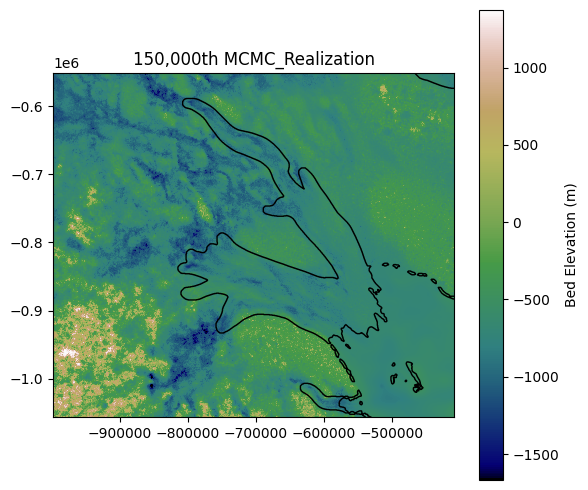

In [40]:
fig2, ax2 = plt.subplots(figsize=(6, 5))
im2 = ax2.pcolormesh(xx, yy, current_beds, cmap='gist_earth')
ax2.axis('scaled')
cbar2 = fig2.colorbar(im2, ax=ax2)
cbar2.set_label('Bed Elevation (m)')
ax2.set_title("150,000th MCMC_Realization")

ax2.contour(xx, yy, highvel_mask, levels=[0.5], colors='black', linewidths=1.0)

plt.tight_layout()
plt.axis('scaled')
plt.savefig("MCMC_Realization.png", dpi=300, bbox_inches='tight')
plt.show()

In [41]:
current_beds.shape, INITIAL_BED.shape, highvel_mask.shape

((1013, 1178), (1013, 1178), (1013, 1178))

Plot saved as 'difference_plot_with_tracks.png'


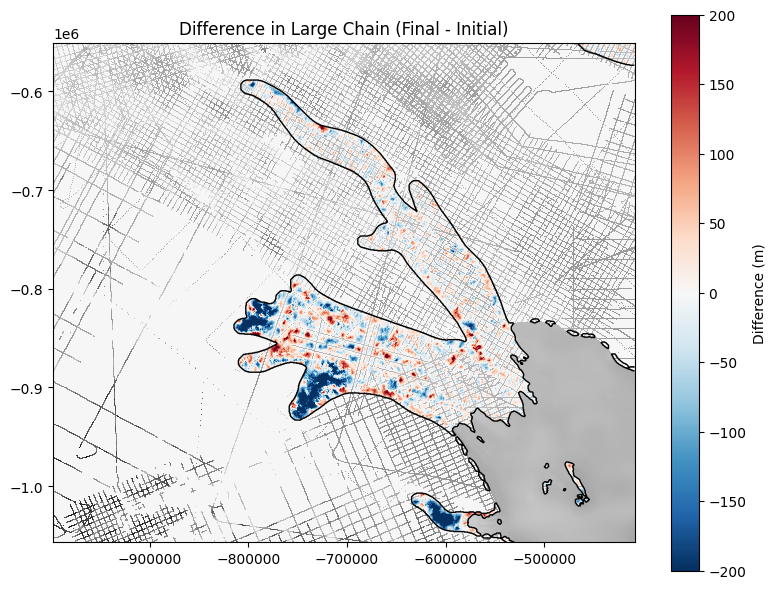

In [42]:
import matplotlib.pyplot as plt
import numpy as np



# --- 2. Create a NEW Figure and a SINGLE Axes ---
fig, ax = plt.subplots(figsize=(8, 6))

# --- 3. Plotting Code (Base Layer) ---
difference = (current_beds - INITIAL_BED)
im3 = ax.pcolormesh(xx, yy, difference, cmap='RdBu_r', vmin=-200, vmax=200)
ax.axis('scaled')
cbar3 = fig.colorbar(im3, ax=ax)
cbar3.set_label('Difference (m)')
ax.set_title("Difference in Large Chain (Final - Initial)")

# --- 4. ADD THE NEW DATA LAYER HERE ---
# This will plot the 'cond_bed' tracks on top of the 'difference' plot
# The default 'viridis' colormap is used, as in your screenshot.
# NaN values in cond_bed will be transparent, showing im3 underneath.
ax.pcolormesh(xx, yy, cond_bed, cmap="Greys") # You can also set vmin/vmax here

# --- 5. Add the Contour Outline ---
# This plots the contour on top of both pcolormesh layers
ax.contour(xx, yy, highvel_mask, levels=[0.5], colors='black', linewidths=1.0)


# --- 6. Improve Layout and Save ---
plt.tight_layout() # Adjusts plot for better spacing
fig.savefig("difference_plot_with_tracks.png", dpi=150) # Save the figure
print("Plot saved as 'difference_plot_with_tracks.png'")

Loading and concatenating files...
File not found, skipping: ./SGS_realizations/0_loss_largeCRF.txt
Plot saved as 'mcmc_loss_combined.png'


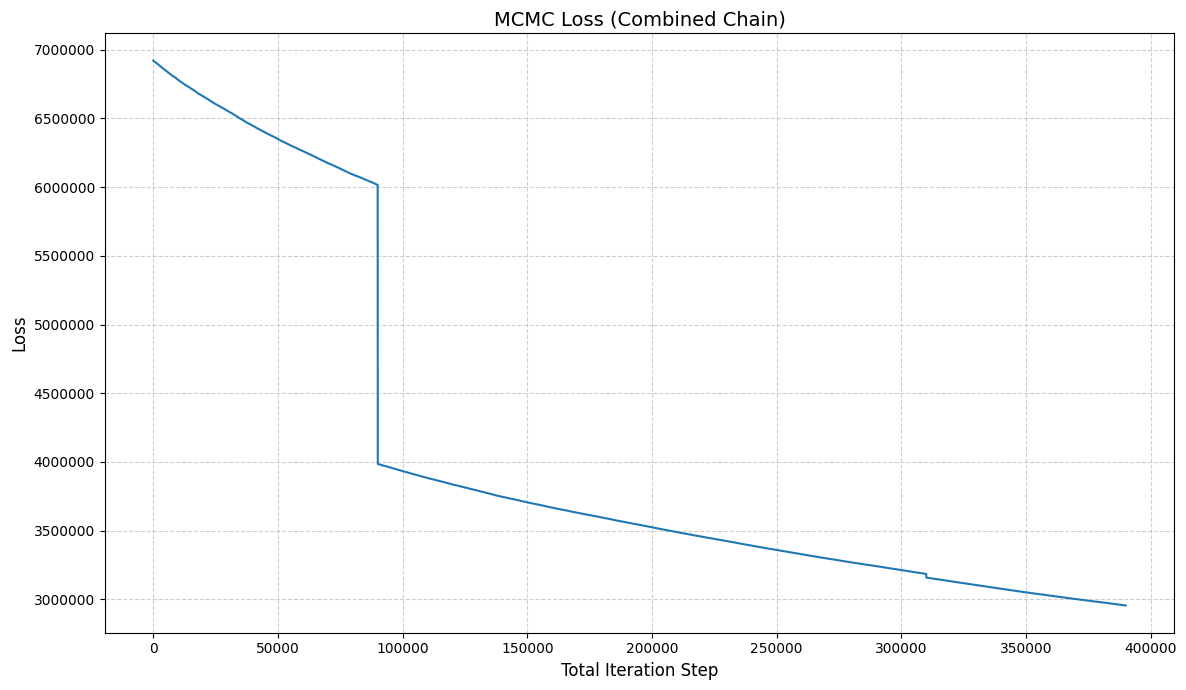

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import os

# --- 1. Load and Concatenate All Files ---
all_losses = []
base_path = './SGS_realizations/'

print("Loading and concatenating files...")
for i in range(index_we_want_compare):
    filename = f'{base_path}{i}_loss_largeCRF.txt'
    
    if os.path.exists(filename):
        try:
            loss_data = np.loadtxt(filename)
            all_losses.append(loss_data)
        except Exception as e:
            print(f"Could not load {filename}: {e}")
    else:
        print(f"File not found, skipping: {filename}")

# Combine all arrays into one long array
if all_losses:
    full_loss_chain = np.concatenate(all_losses)

    # --- 2. Setup Plot ---
    fig, ax = plt.subplots(figsize=(12, 7))

    # --- 3. Plot the Single Combined Line ---
    ax.plot(full_loss_chain)
    
    # --- 4. Customize and Save ---
    ax.set_xlabel("Total Iteration Step", fontsize=12)
    ax.set_ylabel("Loss", fontsize=12)
    ax.set_title("MCMC Loss (Combined Chain)", fontsize=14)
    ax.ticklabel_format(style='plain', axis='y')
    ax.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    fig.savefig("mcmc_loss_combined.png", dpi=150)
    print("Plot saved as 'mcmc_loss_combined.png'")
    # plt.show()
else:
    print("No loss files were found or loaded.")

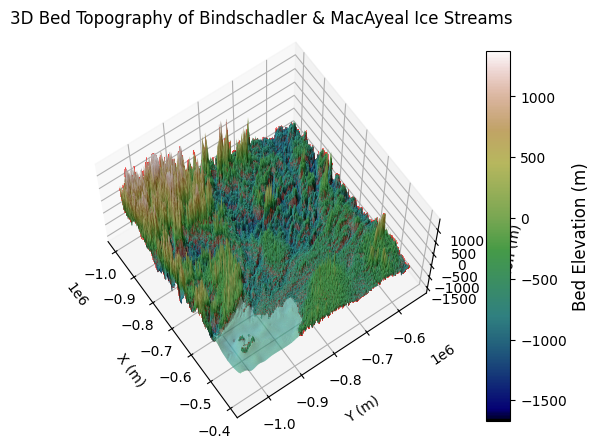

In [44]:
target_bed = current_beds
grounded_mask = largeScaleChain.grounded_ice_mask

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))


ls = LightSource(azdeg=300, altdeg=45)
rgb = ls.shade(target_bed, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='overlay')

ax.plot_surface(xx, yy, target_bed, rstride=1, cstride=1,
                facecolors=rgb, edgecolor='none');


# Grounded Ice
icemask_surface = np.where(grounded_ice_mask == True,target_bed + 10.0,np.nan)
mask_surf = ax.plot_surface(
    xx, yy, icemask_surface,
    color='red',          # gray color
    alpha=0.5,             # semi-transparent
    linewidth=0,
    antialiased=False,
    shade=False
)

# Elevation Colorbar
mappable = cm.ScalarMappable(cmap=cm.gist_earth)
mappable.set_array(target_bed)
cbar = fig.colorbar(mappable, ax=ax, shrink=1.0, aspect=15, pad=0.08)
cbar.set_label("Bed Elevation (m)", fontsize=12)

# --- Labels and titles ---
ax.set_xlabel("X (m)", labelpad=10)
ax.set_ylabel("Y (m)", labelpad=10)
ax.set_zlabel("Elevation (m)", labelpad=10)
ax.set_title("3D Bed Topography of Bindschadler & MacAyeal Ice Streams", pad=20)

ax.view_init(65, -35)
plt.show()

In [1]:

# --- Prepare data ---
target_bed = current_beds
grounded_mask = (largeScaleChain.grounded_ice_mask).astype(bool) # 1/0 to T/F

# --- Create figure with better size and DPI ---
fig = plt.figure(figsize=(16, 12), dpi=150)
ax = fig.add_subplot(111, projection='3d')

# --- Hillshade lighting for terrain ---
ls = LightSource(azdeg=300, altdeg=45)  # Slightly adjusted lighting angle
rgb = ls.shade(
    target_bed, 
    cmap=cm.gist_earth,  
    vert_exag=0.5,    # Increased from 0.1 for more visible relief
    blend_mode='soft'  # 'soft' can give smoother appearance
)

# --- Plot base terrain with reduced stride for smoother appearance ---
surf = ax.plot_surface(
    xx, yy, target_bed, 
    rstride=2, cstride=2,  # Reduced from 1 for better performance
    facecolors=rgb, 
    linewidth=0,
    antialiased=True,  # Enable for smoother look
    shade=False
)

# --- Grounded Ice Overlay ---
offset = 150.0  # Increased significantly for clear visibility
icemask_surface = np.where(grounded_mask == True, target_bed + offset, np.nan)
mask_surf = ax.plot_surface(
    xx, yy, icemask_surface,
    color='orangered',     # More visible than plain red
    alpha=0.7,             # More opaque for better visibility
    edgecolor='none',      
    linewidth=0,
    antialiased=True,
    shade=False
)

# --- Proper Colorbar ---
z_min, z_max = np.nanmin(target_bed), np.nanmax(target_bed)
norm = Normalize(vmin=z_min, vmax=z_max)
mappable = cm.ScalarMappable(cmap=cm.gist_earth, norm=norm)
mappable.set_array(target_bed)  # Use target_bed, not undefined target_bed_smooth

cbar = fig.colorbar(mappable, ax=ax, shrink=0.6, aspect=20, pad=0.12)
cbar.set_label("Bed Elevation (m)", fontsize=13, weight='bold')
cbar.ax.tick_params(labelsize=10)

# --- Set proper axis limits ---
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_zlim(z_min - 100, z_max + offset + 100)  # Add padding

# --- Improve aspect ratio ---
x_range = xx.ptp()
y_range = yy.ptp()
z_range = z_max - z_min
ax.set_box_aspect([x_range, y_range, z_range * 3])  # Exaggerate vertical

# --- Better axis formatting ---
ax.set_xlabel("X (m)", labelpad=15, fontsize=12, weight='bold')
ax.set_ylabel("Y (m)", labelpad=15, fontsize=12, weight='bold')
ax.set_zlabel("Elevation (m)", labelpad=15, fontsize=12, weight='bold')

# Format tick labels to use scientific notation more cleanly
ax.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}'))

# Add "×10⁶" label to axes
ax.text2D(0.5, -0.05, "×10⁶", transform=ax.transAxes, fontsize=10, ha='center')
ax.text2D(-0.05, 0.5, "×10⁶", transform=ax.transAxes, fontsize=10, ha='center', rotation=90)

# --- Enhanced title ---
ax.set_title(
    "Bed Elevation Levels",
    pad=25, 
    fontsize=15,
    weight='bold'
)

# --- Better viewing angle ---
ax.view_init(elev=35, azim=-60)  # Changed azim for better perspective

# --- Add legend ---
legend_elements = [
    Patch(facecolor='tan', edgecolor='black', linewidth=0.5, label='Bed Topography'),
    Patch(facecolor='orangered', alpha=0.7, label=f'Grounded Ice (+{offset}m)')
]
ax.legend(
    handles=legend_elements, 
    loc='upper left', 
    fontsize=11,
    framealpha=0.95,
    edgecolor='black'
)

# --- Cleaner grid ---
ax.grid(True, alpha=0.2, linestyle=':', linewidth=0.5, color='gray')

# --- Background color ---
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('gray')
ax.yaxis.pane.set_edgecolor('gray')
ax.zaxis.pane.set_edgecolor('gray')
ax.xaxis.pane.set_alpha(0.1)
ax.yaxis.pane.set_alpha(0.1)
ax.zaxis.pane.set_alpha(0.1)

# --- Final layout ---
plt.tight_layout()
plt.savefig("Bindschadler_MacAyeal_3D_Enhanced.png", dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

NameError: name 'current_beds' is not defined

In [65]:
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib import cm
from scipy.ndimage import gaussian_filter, binary_erosion
import numpy as np

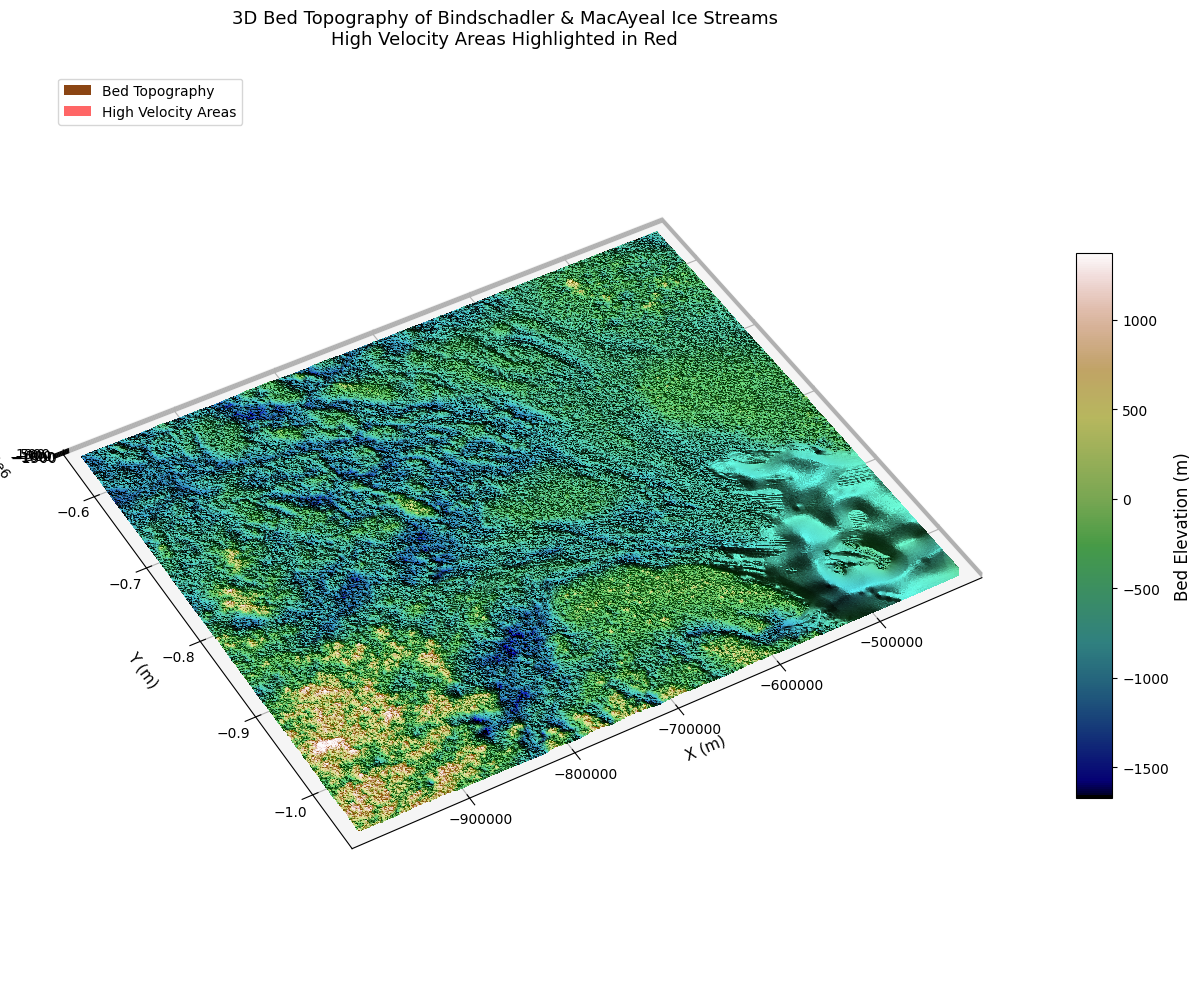

In [66]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import LightSource

# --- Prepare bed elevation data ---
# Use full bed data (don't mask out high velocity areas for the base terrain)
target_bed_smooth = current_beds

# --- Load grounded ice mask ---
# grounded_ice_mask == 0 → grounded ice; 1 → floating
grounded_mask = largeScaleChain.grounded_ice_mask

# --- Create figure and 3D axes ---
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(15, 10))

# --- Hillshade lighting for terrain ---
ls = LightSource(azdeg=300, altdeg=45)
rgb = ls.shade(
    target_bed_smooth,
    cmap=cm.gist_earth,
    vert_exag=1.5,
    blend_mode='overlay'
)

# --- Plot 3D base terrain surface ---
surf = ax.plot_surface(
    xx, yy, target_bed_smooth,
    rstride=1, cstride=1,
    facecolors=rgb,
    linewidth=0,
    antialiased=False,
    shade=False
)

# --- Highlight high velocity areas ---
# Elevate high-velocity regions above the terrain for visibility
offset = 50.0  # Increased offset for better distinction
z_highvel = np.where(highvel_mask, current_beds + offset, np.nan)

# Plot high velocity surface with transparency
highvel_surf = ax.plot_surface(
    xx, yy, z_highvel,
    color='red',
    alpha=0.6,
    edgecolor='darkred',
    linewidth=0.5,
    antialiased=True
)

# --- Set elevation limits (using original bed data, not masked version) ---
z_min = np.nanmin(current_beds)
z_max = np.nanmax(current_beds)

# Adjust z-limits to accommodate elevated high-velocity areas
ax.set_zlim(z_min, z_max + offset * 1.2)

# --- Colorbar for bed elevation ---
# Use current_beds for colorbar range (not the masked version)
mappable = cm.ScalarMappable(
    cmap=cm.gist_earth,
    norm=plt.Normalize(vmin=z_min, vmax=z_max)
)
mappable.set_array(current_beds)
cbar = fig.colorbar(mappable, ax=ax, shrink=0.6, aspect=15, pad=0.08)
cbar.set_label("Bed Elevation (m)", fontsize=12)

# --- Labels and titles ---
ax.set_xlabel("X (m)", labelpad=10, fontsize=11)
ax.set_ylabel("Y (m)", labelpad=10, fontsize=11)
ax.set_zlabel("Elevation (m)", labelpad=10, fontsize=11)
ax.set_title(
    "3D Bed Topography of Bindschadler & MacAyeal Ice Streams\n"
    "High Velocity Areas Highlighted in Red",
    pad=20,
    fontsize=13
)

# --- Adjust aspect ratio & viewing angle ---
ax.set_box_aspect([
    xx.ptp(), 
    yy.ptp(), 
    (z_max - z_min) * 2  # Increased vertical aspect for better visibility
])
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.view_init(elev=45, azim=-120)

# Add a legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='saddlebrown', label='Bed Topography'),
    Patch(facecolor='red', alpha=0.6, label='High Velocity Areas')
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10)

# --- Final layout and save ---
plt.tight_layout()
# plt.savefig("Bindschadler_MacAyeal_3D_HighVelocity.png", dpi=400, bbox_inches='tight')
plt.show()

In [43]:
print(xx.shape, yy.shape, current_beds.shape)


(1013, 1178) (1013, 1178) (1013, 1178)


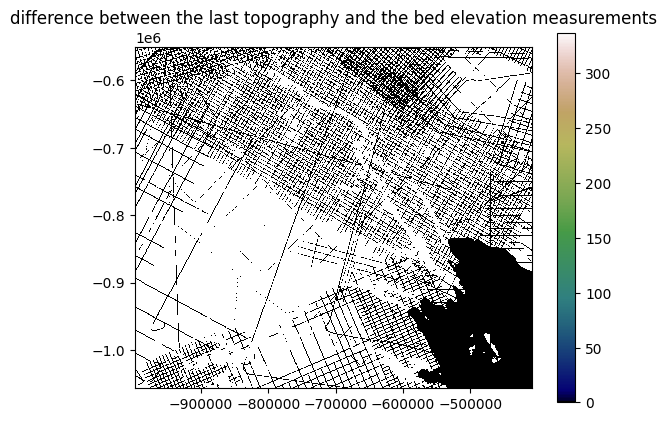

In [47]:
plt.pcolormesh(xx,yy,current_beds - cond_bed,cmap='gist_earth')
plt.title('difference between the last topography and the bed elevation measurements')
plt.axis('scaled')
plt.colorbar()

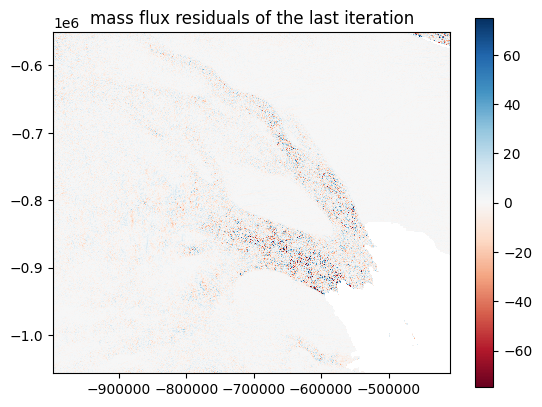

In [48]:
mass_flux_res = Topography.get_mass_conservation_residual(current_beds,bedmap_surf,velx,vely,dhdt,smb,resolution)

plt.pcolormesh(xx,yy,mass_flux_res,cmap='RdBu',vmax=75,vmin=-75)
plt.title('mass flux residuals of the last iteration')
plt.axis('scaled')
plt.colorbar()

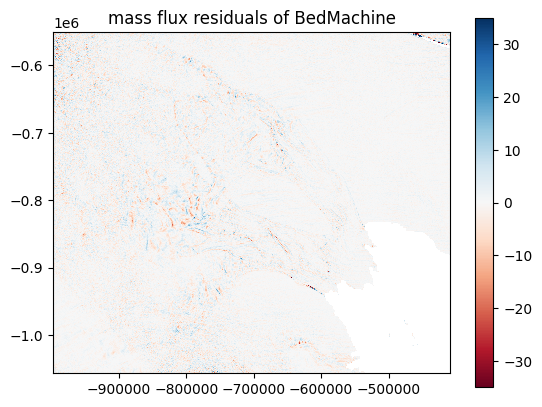

In [49]:
mc_res_bm = Topography.get_mass_conservation_residual(bedmachine_bed,bedmap_surf,velx,vely,dhdt,smb,resolution)

plt.pcolormesh(xx,yy,mc_res_bm,cmap='RdBu',vmax=35,vmin=-35)
plt.title('mass flux residuals of BedMachine')
plt.axis('scaled')
plt.colorbar()

In [88]:
loss_bedmachine = largeScaleChain.loss(mc_res_bm, bedmachine_bed - cond_bed)
loss_mcmc = np.loadtxt(f'{8}_loss_largeCRF.txt')
loss_bedmachine, loss_mcmc

((182270.73586298342, 182270.73586298342, 0.0),
 array([6175096.11402666, 6175096.97086442, 6175088.57110426, ...,
        6091895.59446927, 6091895.55714043, 6091876.55626664]))

In [ ]:
for i in range (i):
    np.concatenate()

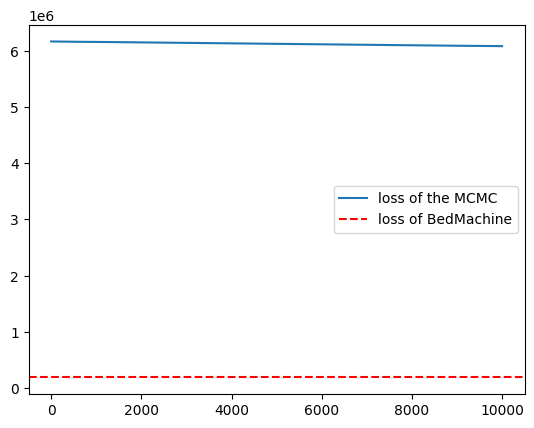

In [89]:
plt.plot(loss_mcmc,label='loss of the MCMC')
plt.axhline(loss_bedmachine[0],ls='--',c='red',label='loss of BedMachine')
plt.legend()

In [97]:
df['simulated_topography'] = beds2[-1].flatten()

In [98]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.15, random_state=42)
df_sampled = df_sampled[df_sampled["simulated_topography"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
#values = df_sampled['simulated_topography']
values = df_sampled['simulated_topography']

maxlag = 80000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata_sim = V1.bins
ydata_sim = V1.experimental
V1_p = V1.parameters

In [99]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df.sample(frac=0.15, random_state=42)
df_sampled = df_sampled[df_sampled["cond_bed"].isnull() == False]
df_sampled = df_sampled[df_sampled["bedmap_mask"]==1]

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['cond_bed']

maxlag = 80000      # maximum range distance
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V2 = skg.Variogram(coords, values, bin_func='even', 
                   n_lags=n_lags, maxlag=maxlag, normalize=False, 
                   model='matern', samples = 0.4)

# extract variogram values
xdata_cond = V2.bins
ydata_cond = V2.experimental
V2_p = V2.parameters

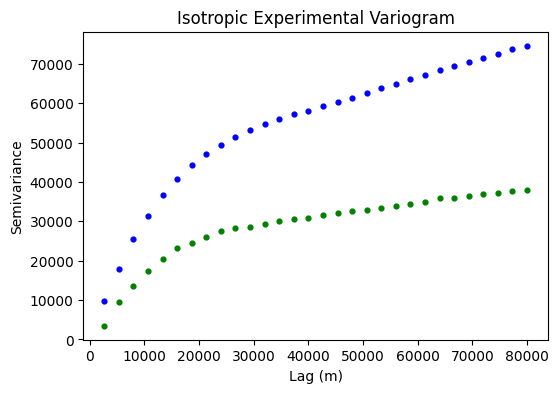

In [100]:
# compare experimental variogram
plt.figure(figsize=(6,4))
plt.scatter(xdata_sim, ydata_sim, s=12, c='b', label='variogram for simulated topography')
plt.scatter(xdata_cond, ydata_cond, s=12, c='g', label='variogram for radar measurements')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

### Save Results

Please remember to save the result for comparison later. For example, I always save the loss of every iteration, the acceptance rate (steps), and some topography.

For example, you can save the topography every 1000 iteration:

In [81]:
beds.shape

(10000, 1013, 1178)

In [83]:
for i in range(0,10000,1000):
    beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used = largeScaleChain.run(n_iter=1000, RF=rf1)
    np.savetxt('loss_'+str(i)+'to'+str(i+1000), loss)
    np.savetxt('steps_'+str(i)+'to'+str(i+1000), steps) 
    np.savetxt('beds_at_' + str(i+1000) +'th_iteration',beds[-1])
    largeScaleChain.intial_bed =beds[-1]

Or you can save beds at more iterations. For the example, the code below save beds for every 100 iteration, while we are running the chain for 1000 iterations

In [84]:
beds, loss_mc, loss_data, loss, steps, resampled_times, blocks_used = largeScaleChain.run(n_iter=1000, RF=rf1)
select_index = np.arange(0,1000,100)
np.savetxt("saved_chains_1.txt", beds[select_index,:,:].reshape(len(select_index), -1))

And these data can be loaded later and concatenated together to showcase the complete chain

In [102]:
beds2.shape

(20000, 1013, 1178)

In [93]:
largeScaleChain.initial_bed = beds2[-1]


A chain can be continued by assigning the initial bed

In [ ]:
largeScaleChain.initial_bed = beds2[-1]

beds2, loss_mc2, loss_data2, loss2, steps2, resampled_times2, blocks_used2 = largeScaleChain.run(n_iter=20000, RF=rf1, rng_seed=rng, only_save_last_bed=False, info_per_iter = 100)

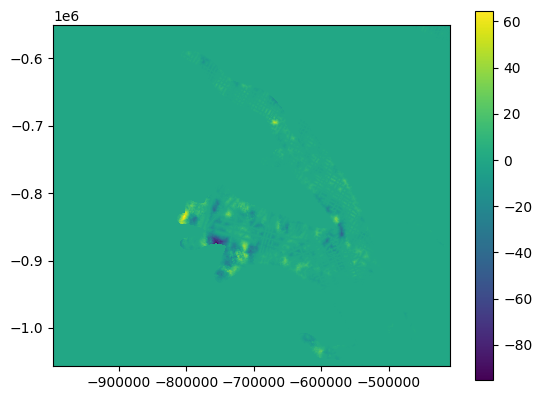

In [94]:
plt.pcolormesh(xx,yy,beds[-1] - beds2[0],cmap='viridis')
plt.axis('scaled')
plt.colorbar()

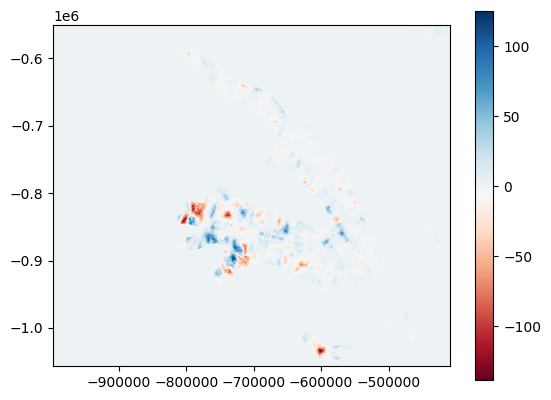

In [95]:
plt.pcolormesh(xx,yy,beds2[-1]-beds2[0],cmap='RdBu')
plt.axis('scaled')
plt.colorbar()

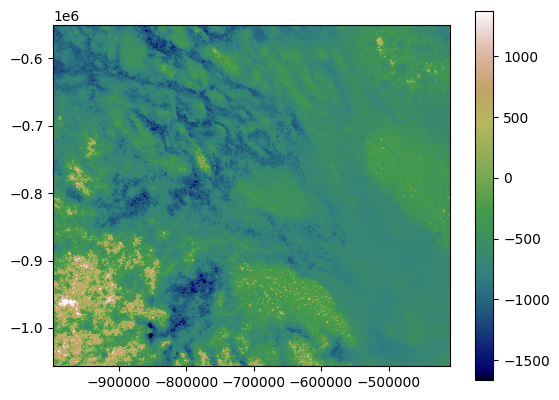

In [108]:
plt.pcolormesh(xx,yy,largeScaleChain.initial_bed,cmap='gist_earth')
plt.axis('scaled')
plt.colorbar()